In [24]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import os
from random import shuffle
import time 
import random

<div class="alert alert-block alert-success">
    We have the dataset in form of a txt file. We will read it in a format that will make seperation of each individual english to Spanish translations easy <br><br>
<b>The dataset is loaded from the site :- https://www.manythings.org/anki/ </b>
</div>


In [2]:
input_file_path     = r'D:\kaggle_trials\spanish2english\spa.txt'
file                = open(input_file_path,mode = 'rt',encoding='utf-8')
text_to_read        = file.read()
file.close()
lines               = text_to_read.strip().split('\n')
text_translate      = [line.split('\t') for line in  lines]
print(text_translate[1:10])
clean_text_translated         = []
for i in range(len(text_translate)):
    text_pair                 = text_translate[i]
    eng_text                  = text_pair[0]
    spanish_text              = text_pair[1]
    
    eng_text_split            = eng_text.split()
    spanish_text_split        = spanish_text.split()
    
    eng_text_punc_removed     = ' '.join([re.sub('[^A-Za-z]+', '', eng_text_split[i]) for i in range(len(eng_text_split))])
    spanish_text_punc_removed = ' '.join([re.sub('[^A-Za-z]+', '', spanish_text_split[i]) for i in range(len(spanish_text_split))])
    
    eng_text_nums_removed     = ' '.join([word.lower() for word in eng_text_punc_removed.split() if word.isalpha()])
    spanish_text_nums_removed = ' '.join([word.lower() for word in spanish_text_punc_removed.split() if word.isalpha()])
    
    eng_text_final            = '<start> '+eng_text_nums_removed + ' <end>'
    spanish_text_final        = '<start> '+spanish_text_nums_removed + ' <end>'
    clean_text_translated.append([eng_text_final,spanish_text_final])
clean_text_translated         = np.array(clean_text_translated)
print('Punctuations removed and all the sentences converted to smaller case.')
print('Example of preprocessed English Sentence is :- ',clean_text_translated[1200][0])
print('Example of preprocessed Spanish Sentence is :- ',clean_text_translated[1200][1])

[['Go.', 'Vete.'], ['Go.', 'Vaya.'], ['Go.', 'Váyase.'], ['Hi.', 'Hola.'], ['Run!', '¡Corre!'], ['Run!', '¡Corran!'], ['Run!', '¡Corra!'], ['Run!', '¡Corred!'], ['Run.', 'Corred.']]
Punctuations removed and all the sentences converted to smaller case.
Example of preprocessed English Sentence is :-  <start> i remember <end>
Example of preprocessed Spanish Sentence is :-  <start> lo recuerdo <end>


In [3]:
clean_text_translated     = clean_text_translated[:10000]
eng_target_statement      = clean_text_translated[:,0]
eng_lang_tokenizer        = tf.keras.preprocessing.text.Tokenizer(filters='')
eng_lang_tokenizer.fit_on_texts(eng_target_statement)
eng_tensor_tokenized      = eng_lang_tokenizer.texts_to_sequences(eng_target_statement)
tensor_english            = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor_tokenized,padding='post')


In [4]:
spanish_input_statement   = clean_text_translated[:,1]
spanish_lang_tokenizer    = tf.keras.preprocessing.text.Tokenizer(filters='')
spanish_lang_tokenizer.fit_on_texts(spanish_input_statement)
spanish_tensor_tokenized  = spanish_lang_tokenizer.texts_to_sequences(spanish_input_statement)
tensor_spanish            = tf.keras.preprocessing.sequence.pad_sequences(spanish_tensor_tokenized,padding='post')


In [5]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(tensor_spanish, tensor_english, test_size=0.2)
max_length_targ = input_tensor_val.shape[1]
max_length_inp  = input_tensor_train.shape[1]


<div class="alert alert-block alert-success">
    <b> Encoder state :</b> The encoder state will consist of a GRU which will output the hidden layer and cell state to be used in the Decoder. We will also initialize the hidden state with zeros dependig upon the batch size to be input into the GRU at one epoch and the embedding dimension.
</div>


In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


<div class="alert alert-block alert-success">
    <b> Attention Cell state : </b> Here we will create one attention layer which will take into account the dense layers W1,W2 and V as explained in the paper. The layers in W1 and W2 will be of dimensions specified by the user in form of units(decoder units). Also it will output the attention weights and the context vector obtained by multiplying the attention weights with the encoder output(hidden state) 
</div>


In [7]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score                 = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights     = tf.nn.softmax(score, axis=1)
        context_vector        = attention_weights * values
        context_vector        = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights



<div class="alert alert-block alert-success">
    <b> Decoder : </b> We will use the output provided by the encoder and then call the Attention class to get the context and use it to decode the output
</div>


In [8]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz  = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru       = tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.fc        = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x                                 = self.embedding(x)
        x                                 = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state                     = self.gru(x)
        output                            = tf.reshape(output, (-1, output.shape[2]))
        x                                 = self.fc(output)
        return x, state, attention_weights


In [2]:
BUFFER_SIZE     = len(input_tensor_train)
BATCH_SIZE      = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim   = 256
units           = 1024
vocab_inp_size  = len(spanish_lang_tokenizer.word_index)+1
vocab_tar_size  = len(eng_lang_tokenizer.word_index)+1
dataset         = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset         = dataset.batch(BATCH_SIZE, drop_remainder=True)

NameError: name 'input_tensor_train' is not defined

In [1]:
example_input_batch, example_target_batch = next(iter(dataset))
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
# attention_layer = BahdanauAttention(10)
# attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

# print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
# print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
# decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
#                                       sample_hidden, sample_output)

# print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

NameError: name 'dataset' is not defined


<div class="alert alert-block alert-success">
    <b> Loss function to be used in Teacher Forcing: </b> We create a loss function here to compute losses 
</div>


In [11]:
optimizer   = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask   = tf.math.logical_not(tf.math.equal(real, 0))
    loss_  = loss_object(real, pred)
    mask   = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


<div class="alert alert-block alert-success">
    <b> Teacher Forcing and training : </b> We train our model here and we will be using Teacher forcing where the input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
</div>


In [12]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden     = encoder(inp, enc_hidden)
        dec_hidden                 = enc_hidden
        dec_input                  = tf.expand_dims([eng_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input                  = tf.expand_dims(targ[:, t], 1)

    batch_loss                     = (loss / int(targ.shape[1]))
    variables                      = encoder.trainable_variables + decoder.trainable_variables
    #print(variables)
    gradients                      = tape.gradient(loss, variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss


<div class="alert alert-block alert-success">
    <b>Performing Training : </b> We start training our model here using all the classes mentioned above
</div>


In [13]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [14]:
checkpoint_dir    = r'D:\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint        = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [15]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.1347
Epoch 1 Batch 100 Loss 2.3982
Epoch 1 Loss 2.6719
Time taken for 1 epoch 21.68782615661621 sec

Epoch 2 Batch 0 Loss 2.2504
Epoch 2 Batch 100 Loss 2.1083
Epoch 2 Loss 2.1093
Time taken for 1 epoch 12.382484197616577 sec

Epoch 3 Batch 0 Loss 1.8786
Epoch 3 Batch 100 Loss 1.7688
Epoch 3 Loss 1.7895
Time taken for 1 epoch 9.947962284088135 sec

Epoch 4 Batch 0 Loss 1.4915
Epoch 4 Batch 100 Loss 1.4484
Epoch 4 Loss 1.5170
Time taken for 1 epoch 12.360455989837646 sec

Epoch 5 Batch 0 Loss 1.1549
Epoch 5 Batch 100 Loss 1.2248
Epoch 5 Loss 1.2750
Time taken for 1 epoch 9.986894845962524 sec

Epoch 6 Batch 0 Loss 0.9722
Epoch 6 Batch 100 Loss 1.1004
Epoch 6 Loss 1.0520
Time taken for 1 epoch 12.138469457626343 sec

Epoch 7 Batch 0 Loss 0.8444
Epoch 7 Batch 100 Loss 0.9013
Epoch 7 Loss 0.8440
Time taken for 1 epoch 9.985242128372192 sec

Epoch 8 Batch 0 Loss 0.6904
Epoch 8 Batch 100 Loss 0.6106
Epoch 8 Loss 0.6526
Time taken for 1 epoch 12.231571435928345 sec

Epoc

In [16]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    spanish_text_split        = sentence.split()
    spanish_text_punc_removed = ' '.join([re.sub('[^A-Za-z]+', '', spanish_text_split[i]) for i in range(len(spanish_text_split))])
    spanish_text_nums_removed = ' '.join([word.lower() for word in spanish_text_punc_removed.split() if word.isalpha()])
    sentence                  = '<start> '+spanish_text_nums_removed + ' <end>'
    inputs = [spanish_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                       maxlen=input_tensor_train.shape[1],
                                                       padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([eng_lang_tokenizer.word_index['<start>']], 0)

    for t in range(input_tensor_val.shape[1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += eng_lang_tokenizer.index_word[predicted_id] + ' '

        if eng_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [17]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [27]:
def translate(sentence,actual):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Actual Translation :- ',actual)
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [41]:
def generate_translation_randomly():
    word_index_dictionary_inputs = spanish_lang_tokenizer.word_index
    index_word_dictionary        =  {v: k for k, v in word_index_dictionary_inputs.items()}

    eng_word_index_dictionary_inputs = eng_lang_tokenizer.word_index
    eng_index_word_dictionary        =  {v: k for k, v in eng_word_index_dictionary_inputs.items()}

    j = random.randint(0,2000)
    spanish_sentence_list = [index_word_dictionary[i] if i>0 else '' for i in input_tensor_val[j] ] 
    input_sent = ' '.join(spanish_sentence_list)
    input_sent = input_sent.replace('<end>','').replace('<start>','')


    english_sentence_list = [eng_index_word_dictionary[i] if i>0 else '' for i in target_tensor_val[j]] 
    input_sent_eng = ' '.join(english_sentence_list)
    input_sent_eng = input_sent_eng.replace('<end>','').replace('<start>','')

    translate(input_sent.strip(),input_sent_eng.strip())

Input: <start> ya vers <end>
Actual Translation :-  you will see
Predicted translation: youll see <end> 


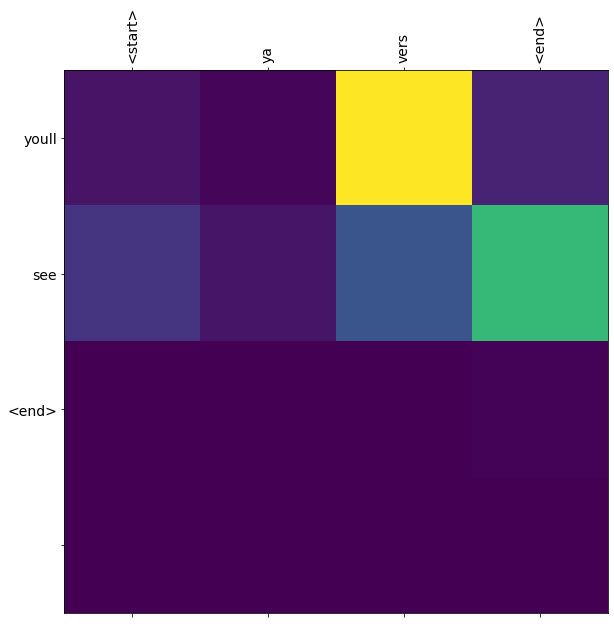

In [49]:
generate_translation_randomly()

Input: <start> mira de cerca <end>
Actual Translation :-  look closely
Predicted translation: watch closely <end> 


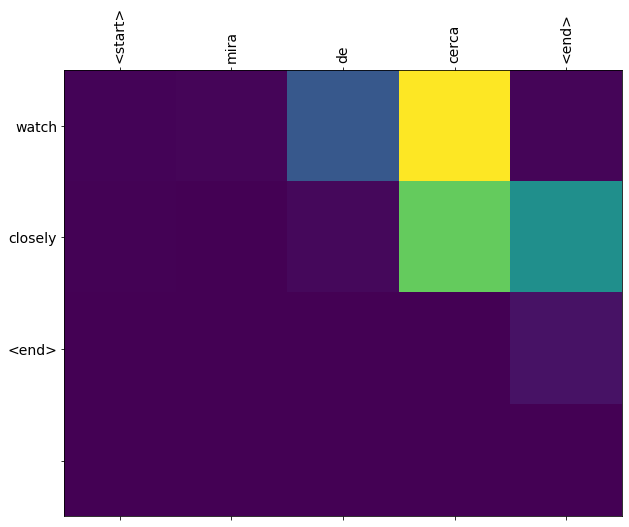

In [50]:
generate_translation_randomly()

Input: <start> estn listos <end>
Actual Translation :-  are you ready
Predicted translation: theyre smart <end> 


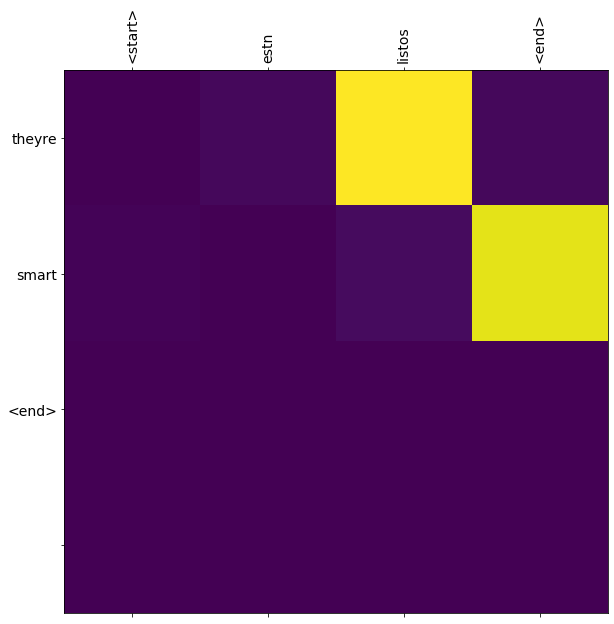

In [51]:
generate_translation_randomly()